# Using Multiple Linear Regression to Predict Compressive Strength of Concrete

Compressive strength refers to the ability of a material to withstand a compressive load (forces acting to reduce the of a material) without fracturing. The opposite of compressive strength is tensile strength, which resists forces acting to stretch or elongate the material. 

In the construction industry, concrete is frequently graded according to its compressive strength, measured by MPa (Megapascals) or psi (pounds per square inch). To assess the compressive strength of a certain type of concrete, cube or Cylinder samples are usually tested under a loading machine which progressively increases compressive forces until the sample shows signs of failure. The testing requisites can differ from country to country based on the design code. The compressive strength of concrete is calculated by the failure load divided with the cross sectional area resisting the load and reported in pounds per square inch in US customary units and mega pascals (MPa) in SI units. Concrete's compressive strength requirements can vary from 2500 psi (17 MPa) for residential concrete to 4000psi (28 MPa) and higher in commercial structures. Higher strengths upto and exceeding 10,000 psi (70 MPa) are specified for certain applications.

![alt text](https://1.bp.blogspot.com/-vGgLkE0TVzk/XVGUHgOFiRI/AAAAAAAAA_4/SAkQv53IELwhx7EeFljz6AfgrQiRck1FgCLcBGAs/s640/Different%2BGrades%2Bof%2BConcrete.JPG)

This dataset of more than a thousand samples of concrete was created by:
Original Owner and Donor
Prof. I-Cheng Yeh
Department of Information Management
Chung-Hua University,
Hsin Chu, Taiwan 30067, R.O.C.

The actual concrete compressive strength (MPa) for a given mixture under a specific age (days) was determined from laboratory. Data is not scaled and is in raw form. Although compressive strength of concrete is a highly nonlinear function of age and proportions of ingredients, and there is ongoing scientific research to derive the exact relationships between variables, I will attempt to analyze this dataset using simple Ordinary Least Squares (OLS) regression. This study aims to prove that even extremely simple, barebones computational mathematical models can be used to predict a material's strength to a decent degree of accuracy. 

## Importing raw data

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
orig_data = pd.read_csv("/content/datasets_31540_40381_compresive_strength_concrete.csv")
raw_data = orig_data.copy()
raw_data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


The features are listed below:


*   Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable
* Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable
* Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable
* Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable
* Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable
* Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable
* Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable
* Age -- quantitative -- Day (1~365) -- Input Variable
* Concrete compressive strength -- quantitative -- MPa -- Output Variable

Each sample essentially shows the proportions of ingredients within the specific mixture. 



## Exploratory Data Analysis

In [7]:
#renaming columns
raw_data = raw_data.rename(columns={'Cement (component 1)(kg in a m^3 mixture)':"cement",
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)':"furnace_slag",
       'Fly Ash (component 3)(kg in a m^3 mixture)':"fly_ash",
       'Water  (component 4)(kg in a m^3 mixture)':"water",
       'Superplasticizer (component 5)(kg in a m^3 mixture)':"super_plasticizer",
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)':"coarse_agg",
       'Fine Aggregate (component 7)(kg in a m^3 mixture)':"fine_agg", 'Age (day)':"age",
       'Concrete compressive strength(MPa, megapascals) ':"compressive_strength"})
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cement                1030 non-null   float64
 1   furnace_slag          1030 non-null   float64
 2   fly_ash               1030 non-null   float64
 3   water                 1030 non-null   float64
 4   super_plasticizer     1030 non-null   float64
 5   coarse_agg            1030 non-null   float64
 6   fine_agg              1030 non-null   float64
 7   age                   1030 non-null   int64  
 8   compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


There are a total of 1030 instances in this dataset. Fortunately, all features (cement, furnace_slag, fly_ash, etc.) seem to have no missing values so no extensive data cleaning is required. 

In [8]:
raw_data.describe()

,cement,furnace_slag,fly_ash,water,super_plasticizer,coarse_agg,fine_agg,age,compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Mean refers to the mathematical mean of the data points for the corresponding feature. STD is the standard deviation. The subsequent rows show the quartiles for the data as well as the minimum and maximum. Looking at min and max, we can see that there the scales for each feature are quite different. For instance, the **cement** feature has a min of 102 and a max of 540, which gives it a range of 438, while **super_plasticizer** has a range of 22. ML models work best when all features have similar scales, so this means that we will have to standardize all of the data before fitting a regression model. 

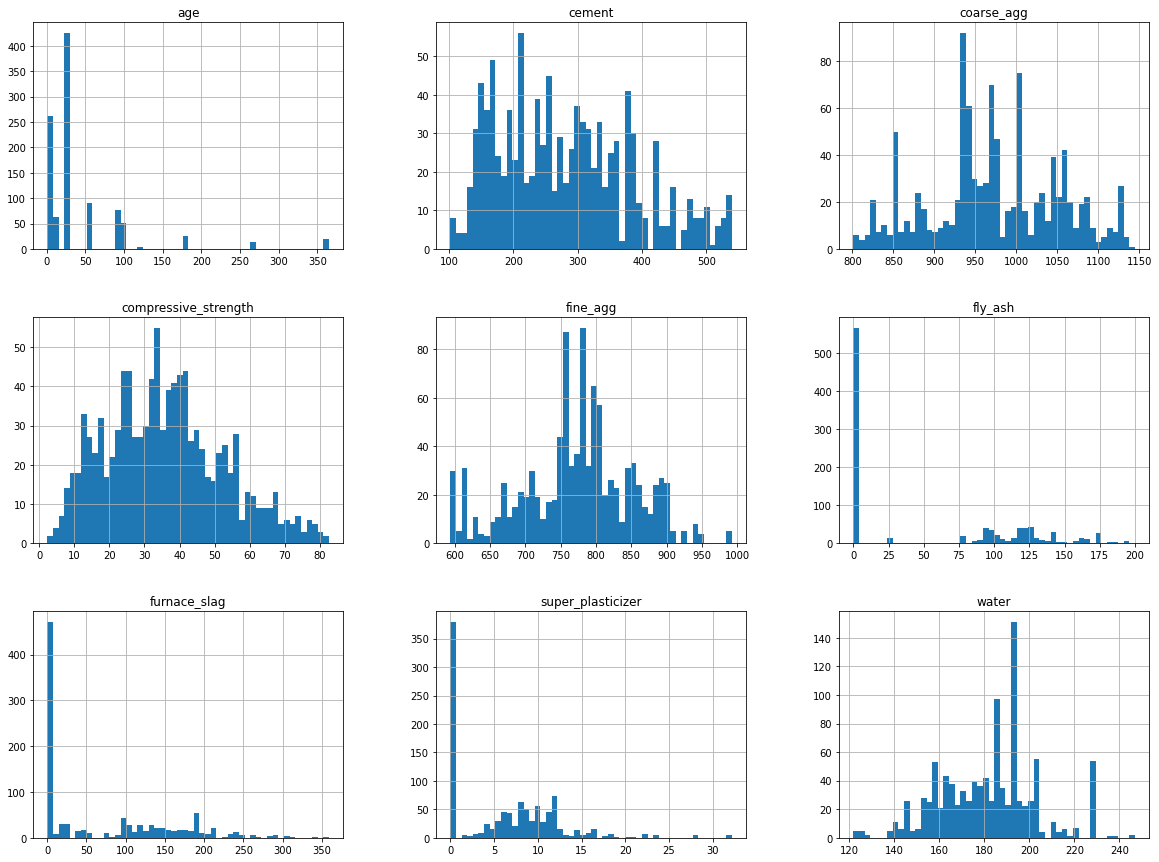

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
raw_data.hist(bins=50, figsize=(20,15))
plt.show()

These graphs show the distribution of values for each feature as a histogram. Some features have decent bell-shaped distributions but others are heavy-tailed, meaning that values are concentrated on one end of the distribution. For example most of the samples have an age of under 50 days, even though the maximum recorded value is 365. This may make discerning patterns in the data more difficult. However, the target feature, **compressive strength**, does have a decent bell-shaped distribution. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


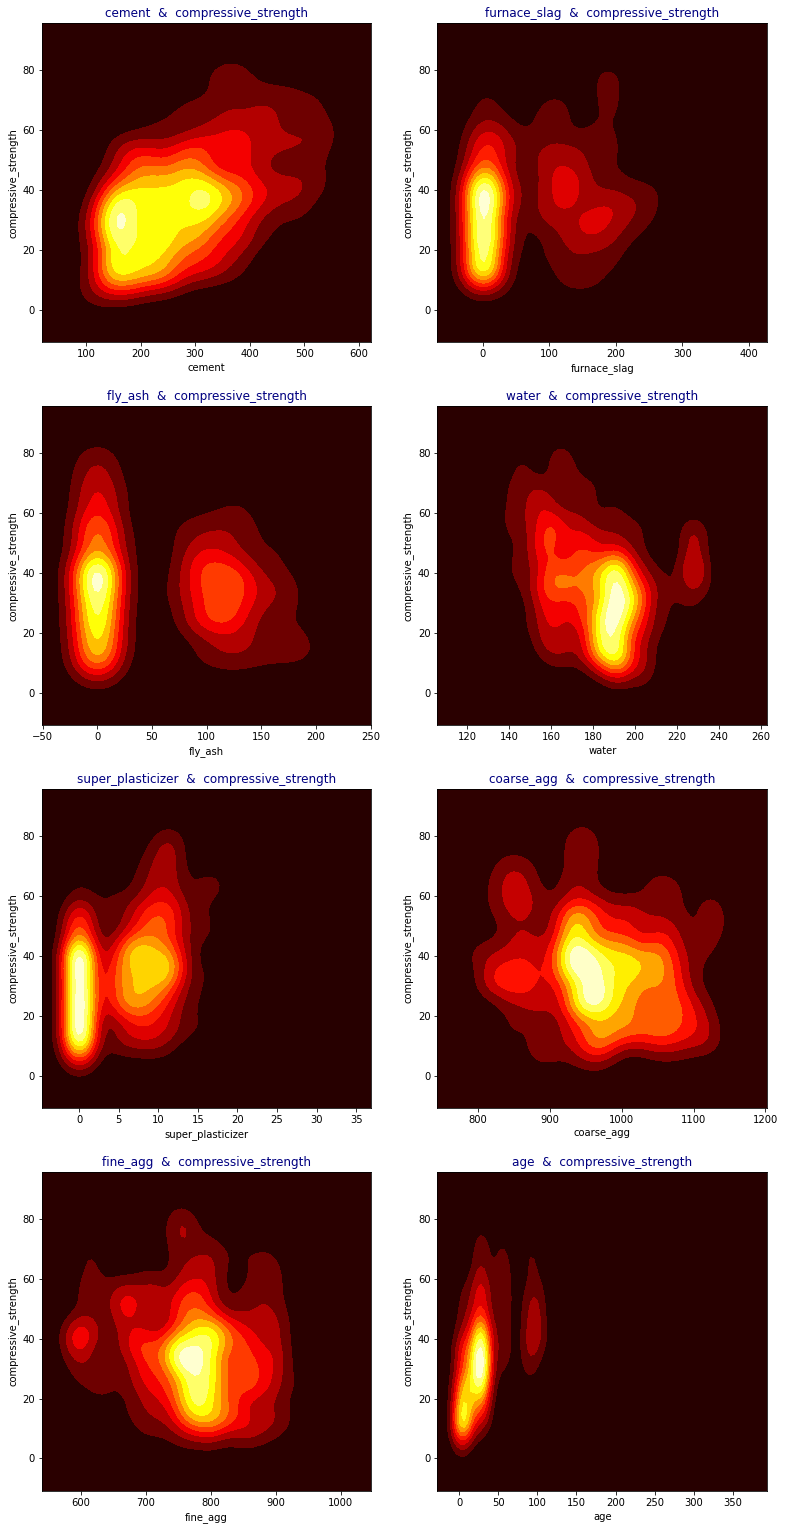

In [12]:
import itertools
import seaborn as sns
cols = [i for i in raw_data.columns if i not in 'compressive_strength']
length = len(cols)

plt.figure(figsize=(13,27))
for i,j in itertools.zip_longest(cols,range(length)):
    plt.subplot(4,2,j+1)
    sns.kdeplot(raw_data[i],
                raw_data["compressive_strength"],
                cmap="hot",
                shade=True)
    plt.title(i+"  &  compressive_strength",color="navy")

The above graphs are contour plots comparing **compressive strength** against each feature. Bright spots indicate a greater frequency of data points in that range

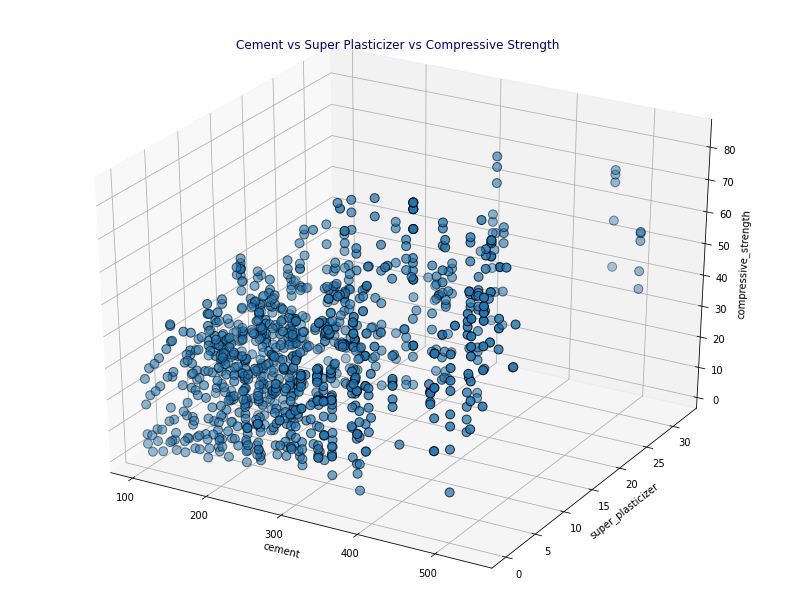

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,11))

ax  = fig.gca(projection = "3d")
#plt.subplot(111,projection = "3d") 

plot =  ax.scatter(raw_data["cement"],
           raw_data["super_plasticizer"],
           raw_data["compressive_strength"],
           linewidth=1,edgecolor ="k", 
           s=80 )

ax.set_xlabel("cement")
ax.set_ylabel("super_plasticizer")
ax.set_zlabel("compressive_strength")

plt.title("Cement vs Super Plasticizer vs Compressive Strength",color="navy")
plt.show()

This is a 3D graph plotting **cement** against **super_plasticizer** and **compressive strength**. One observation that can be made is that the more cement and super plasticizer there is in the sample, the greater the compressive strength, as shown by the few outliers in the right of the graph. 

### Splitting Data into Training and Testing Data

It is important to split the data so that we can fit the regression model on the training data only and have a testing set to evaluate its performance in a real-world setting. 

In [0]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(raw_data, test_size=0.2, random_state=42)
x_train = train_set.drop('compressive_strength', axis=1)
y_train = train_set[['compressive_strength']]
x_test = test_set.drop('compressive_strength', axis=1)
y_test = test_set[['compressive_strength']]
corr_matrix = train_set.corr()
corr_matrix["compressive_strength"].sort_values(ascending=False)

This output shows the correlation coefficient (Pearson's r) of each feature with the target feature, which in this study is the compressive strength of the sample of concrete. Most features have very weak correlations, with cement having the strongest correlation of 0.496686. Hopefully, with multiple linear regression, a model may be able to find a decent pattern to bring together all of these features.  

In [0]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
sm = scatter_matrix(train_set, figsize=(15,15), diagonal = 'kde')
#Changing label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(45) for s in sm.reshape(-1)]
#Changing offset for label
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
#Hiding ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]
plt.show()

This is a matrix of scatter plots between each of the features. The diagonal is a distribution graph because a graph can't plot a feature against itself. There seem to be no significant correlations between any two features excluding the target feature. We can use a heatmap to verify this observation. 

In [0]:
import seaborn as sns
sns.heatmap(train_set.corr().abs())
plt.show()

There is a moderate degree of correlation between **super_plasticizer** and **water** with a r of 0.6. There is also another weak but still interesting correlation between **fine_agg** and **water**. We could try experimenting with combining these attributes to see if they show a higher degree of correlation with the target feature. For instance, we could combine **super_plasticizer** and **water** to create a feature named **"proportion of super plasticizer to water"**. We can add the two combined attributes and calculate the correlation with the target feature again. 

In [0]:
train_set['water_per_sp'] = train_set['water']/train_set['super_plasticizer']
train_set['fa_per_water'] = train_set['fine_agg']/train_set['water']
corr_matrix = train_set.corr()
corr_matrix['compressive_strength'].sort_values(ascending=False)

The two combined attributes we added were **water_per_sp** and **fa_per_water**. We can see that the r value between these attributes and the target feature is less than the original features'. We will drop these combinatory attributes for now. 

In [0]:
train_set = train_set.drop('water_per_sp', axis=1)
train_set = train_set.drop('fa_per_water', axis=1)
train_set

## Preparing Data for Regression

We can now scale the data to prepare it for regression. There are two types of feature scaling. 
* Min-max scaling, also called normalization, subtracts the min value and divides by max minus the min to place all values on a scale of 0 to 1. The drawbacks of this type of scaling is that values are bound to narrow range, which may be problematic for some types of regression analysis. 
* Standardization subtracts the mean value and then divides by the standard deviation so that the resulting distribution has unit variance. For this dataset, standardization seems more appropriate due to the large scales of some attributes. 

In [0]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train_scaled = ss.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_train_scaled

## Fitting a Linear Regressor to Training Data

In [0]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
print('Coefficients: \n', lr.coef_)

These are the coefficients for the Multiple Linear Regression equation that was calculated. Because the data was standardized prior to fitting the linear regressor, these coefficients actually refer to the relative importances of each feature in making a prediction. Thus, in this dataset, **cement**, which has a coefficient of 12.79, is the most important feature in predicting compressive strength. The equation for a multiple linear regression model is shown below: 

![](http://)![](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/39_blog_image_1.png)

**LinearRegression()** finds the weights **b** that minimizes the residuals between the points and the line of best fit. 

## Evaluating our Model

In [0]:
predictions = lr.predict(x_train_scaled)
labels = y_train.to_numpy()
p_vs_actual = pd.DataFrame(predictions)
labels = pd.DataFrame(labels)
p_vs_actual.columns = ['Predictions']
labels.columns = ['Actual']
p_vs_actual['Actual Values'] = labels['Actual']
p_vs_actual

In [0]:
p_vs_actual['Residuals'] = p_vs_actual['Actual Values'] - p_vs_actual['Predictions']
p_vs_actual[['Residuals']].describe()

Here, you can see that the max residual was 34.5 MPa. That doesn't seem too good considering that the max value for compressive strength is about 82 MPa. Below is a plot comparing the predicted values against the actual values. If it were a perfect model, the points would line up in a perfectly straight line. 

In [0]:
p_vs_actual.plot(kind='scatter', x='Actual Values', y='Predictions')

In [0]:
from sklearn.metrics import mean_squared_error, r2_score
lin_mse = mean_squared_error(labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rsq = r2_score(labels, predictions)
print('Mean Squared Error:', lin_mse)
print('Root Mean Squared Error:', lin_rmse)
print('R Squared:', lin_rsq)

The multiple linear regression model achieves a RMSE of 10.518 and R^2 of 0.61 on the training set. Using cross validation, we can divide the training set into 10 smaller sets and evaluate the model on every subset. The RMSE for each set as well as the mean and standard deviation is listed in the output below. 

In [0]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, x_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

display_scores(lin_rmse_scores)

In [0]:
corr_matrix = train_set.corr()
corr_matrix["compressive_strength"].sort_values(ascending=False)

## Testing out a less complex model

Recall from earlier in this notebook that some of the features show very weak correlation with the target feature, and that we could try experimenting with dropping some features in order to reduce the complexity of the model. Reduced complexity, or number of features, may or may not be beneficial. Below, I have tried dropping three of the features with the weakest correlation. 

In [0]:
raw_data_dropped = raw_data.drop(['furnace_slag', 'fly_ash', 'fine_agg'], axis=1)
train_dropped, test_dropped = train_test_split(raw_data_dropped, test_size=0.2, random_state=42)
x_train_dropped = train_dropped.drop('compressive_strength', axis=1)
y_train_dropped = train_dropped[['compressive_strength']]
x_test_dropped = test_dropped.drop('compressive_strength', axis=1)
y_test_dropped = test_dropped[['compressive_strength']]
scaler = StandardScaler()
x_train_dropped_scaled = scaler.fit_transform(x_train_dropped)
x_train_dropped_scaled = pd.DataFrame(x_train_dropped_scaled, columns = x_train_dropped.columns)
lr_dropped = LinearRegression()
lr_dropped.fit(x_train_dropped_scaled, y_train_dropped)
print('Coefficients: \n', lr_dropped.coef_)

In [0]:
pred_dropped = lr_dropped.predict(x_train_dropped_scaled)
labels_dropped = y_train_dropped.to_numpy()
pvsaccdropped = pd.DataFrame(pred_dropped)
labels_dropped = pd.DataFrame(labels_dropped)
pvsaccdropped.columns = ['Predictions']
labels_dropped.columns = ['Actual']
pvsaccdropped['Actual Values'] = labels_dropped['Actual']
pvsaccdropped.plot(kind='scatter', x='Predictions', y='Actual Values')

In [0]:
dropped_mse = mean_squared_error(labels_dropped, pred_dropped)
dropped_rmse = np.sqrt(dropped_mse)
print('Root Mean Squared Error:', dropped_rmse)

In [0]:
y_test.shape

The model with dropped features performed worse than the original model. This means that the features that were just dropped may be essential after all. Since we now know that the original model with no dropped features performs the best, we can finally evaluate it on the test set. It has never 'seen' this data before, so this will be an accurate real-world test of this regression model. 

In [0]:
#Standardizing test data
x_test_scaled = ss.transform(x_test)
final_predictions = lr.predict(x_test_scaled)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rsq = r2_score(y_test, final_predictions)
adj_rsq = 1-(1-final_rsq)*(206-1)/(206-8-1)
print('R Squared:', lin_rsq)
print('Final Adjusted R squared:', adj_rsq)
print('Final RMSE score:', final_rmse)

The model achieved a final RMSE of 9.796 and an R^2 of 0.61. I also calculated the adjusted R^2 value to show a more accurate value taking sample size (206 instances in test set, 8 independent variables) into consideration. 

## Analysis and Conclusion

This project demonstrated that even a simple Multiple Linear Regression model could be used to model the relationship between the proportions of ingredients in concrete and its compressive strength. Although accuracy wasn't high enough to warrant a real-world use of this model, an adjusted R^2 value of 0.61 shows that the multivariate equation utilized by the model was statistically significant. In addition, I was able to find the ingredient that was most important in calculating strength by looking at the coefficients. Because this dataset describes all of the attributes for a given sample of concrete, a change in the quantity of a specific ingredient is not only correlated to, but directly causes a change in the compressive strength of the sample. 

This model could be improved by experimenting with different combinations of features (dropping, combining, etc.) aside from the ones used in this notebook. In addition, a more powerful model such as those using ensemble methods (Random Forest, Adaboost, Gradient Tree Boosting, etc) would most likely yield more accurate results. This is because they use multiple algorithms together to predict values, which is objectively more effective than using a single algorithm alone. 

The multivariate equation of best fit was used to predict the dependent variable, compressive strength, in this study. This model is beneficial for the construction industry because currently, concrete needs to be tested in a laboratory using expensive equipment. Being able to predict a batch of concrete's compressive strength solely using a few lines of code would save a lot of financial resources and time. In addition, a mathematical model could be used to calculate the compressive strength of just about any building material, provided the proportions of ingredients used to make it. This relates to my X-day because when humans eventually begin to build settlements on Mars, they will need to know the specific strength of the material they are using to decide how to purpose it. This is especially true when materials already existent on Mars are used to build structures. It is unclear just how abundant natural building materials are on the red planet, and it would be costly to transport construction equipment from Earth. Once a clear idea of what is available on Mars is made, a similar mathematical model to the one used in this study can be used to predict the strengths of structures that can be made from them. 

In conclusion, a Multiple Linear Regression model can be used to predict the performance of a building material to a moderate degree of accuracy. 